In [1]:
its_jupyter_notebook = True

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sys.path.insert(0, '..')

from util.evaluation import load_paris_results, load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df, plot_histogram_01, remove_outliers, log_func, load_res_and_tools, plot_all_model_auc, plot_all_model_auc, obtain_all_model_auc, obtain_subset_from_task, plot_results_of_all_models, obtain_sr_nosr, make_plot_kde_and_test_difference
from util.plot_utils import plot_results_based_on_treshold_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models
# %load_ext autoreload
# %autoreload 2

from config import *
from models.nt_classifier import build as build_model 
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

<class 'transformers.tokenization_dna.DNATokenizer'>


In [2]:
datasets = ['paris', 'ricseq', 'splash', 'mario']
tools = ['priblast', 'risearch2'] #['priblast', 'RNAup', 'RNAplex', 'RNAhybrid', 'rnacofold', 'risearch2', 'assa']
energy_columns = tools + ['E_norm']

#ARGS for paris
SPECIE_PARIS = 'human'
PARIS_HQ = False
PARIS_HQ_THRESHOLD = 35
MIN_N_READS_RICSEQ = 4
RICSEQ_HQ = False

RICSEQ_TEST = False
SPLASH_TEST = True

#ARGS for splash, ricseq, mario


args_datasets = {'paris':
                 {'only_test' : np.nan, #uneuseful for paris
                  'exclude_train_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_genes' : np.nan, #uneuseful for paris
                  'exclude_paris_couples' : np.nan, #uneuseful for paris
                  'filter_hq_ricseq' : np.nan, #uneuseful for paris
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for paris
                  'SPECIE_PARIS' : SPECIE_PARIS,
                  'PARIS_HQ':PARIS_HQ,
                  'PARIS_HQ_THRESHOLD':PARIS_HQ_THRESHOLD,
                 }, 
                 'ricseq': 
                 {'only_test' : RICSEQ_TEST,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : RICSEQ_HQ,
                  'MIN_N_READS_RICSEQ' : MIN_N_READS_RICSEQ,
                  'SPECIE_PARIS' : np.nan, #uneuseful for ricseq
                  'PARIS_HQ':np.nan, #uneuseful for ricseq
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for ricseq
                 },
                 'splash': 
                 {'only_test' : SPLASH_TEST,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for splash
                  'MIN_N_READS_RICSEQ' : np.nan, #uneuseful for splash
                  'SPECIE_PARIS' : np.nan, #uneuseful for splash
                  'PARIS_HQ':np.nan, #uneuseful for splash
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for splash
                 },
                'mario': 
                 {'only_test' : False,
                  'exclude_train_genes' : False,
                  'exclude_paris_genes' : False,
                  'exclude_paris_couples' : True,
                  'filter_hq_ricseq' : False, #uneuseful for mario
                  'MIN_N_READS_RICSEQ' : np.nan,  #uneuseful for mario
                  'SPECIE_PARIS' : np.nan, #uneuseful for mario
                  'PARIS_HQ':np.nan, #uneuseful for mario
                  'PARIS_HQ_THRESHOLD':np.nan, #uneuseful for mario
                 },
}

args_datasets['test'] = args_datasets['paris'] #sometimes I want to call it 'test'

In [3]:
nt_models = ['all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083',
             'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039_NOWENHNokSN_PARISFINETUNINGtrainhqSPLASHval0043', 
             'all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0079',
            ]

In [4]:
checkpoint_dir = os.path.join(ROOT_DIR, 'checkpoints', nt_models[0]) 
#'less_samples_in_train',
#all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151
# all_modelarch2_easypretrain3_paristfinetuning14_ricseq23_splash151_trainall0198

DATASET: paris
easypos_smartneg


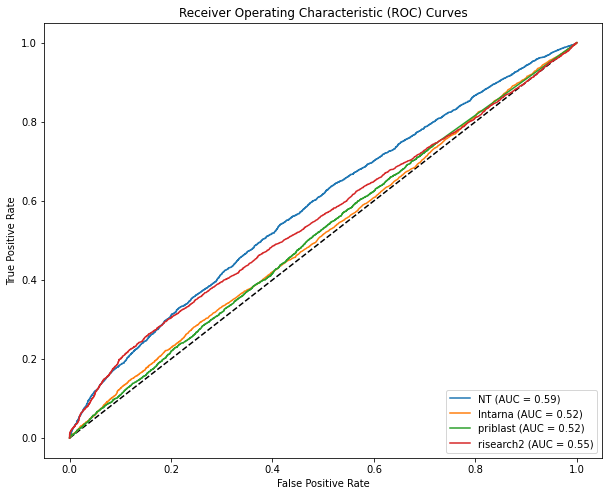

ephnen


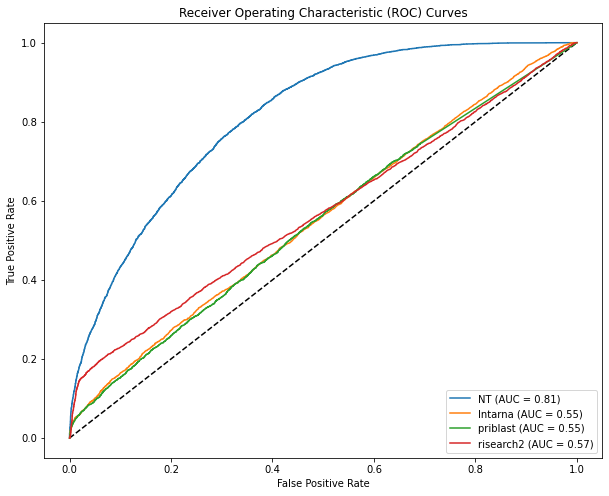

enhn500


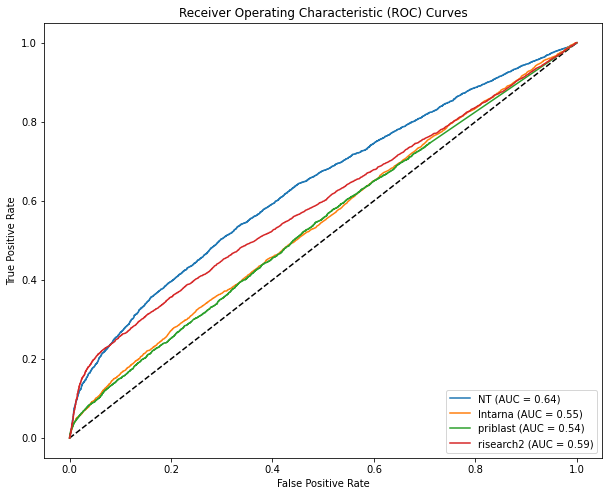




# excluded couples:  234
# excluded couples:  234
# excluded couples:  234
DATASET: ricseq
easypos_smartneg


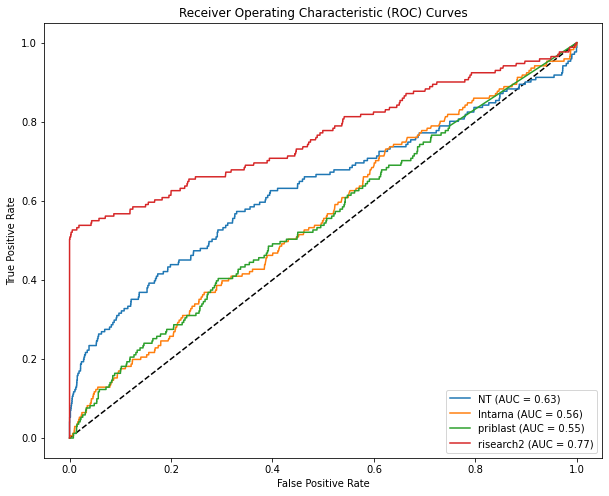

ephnen


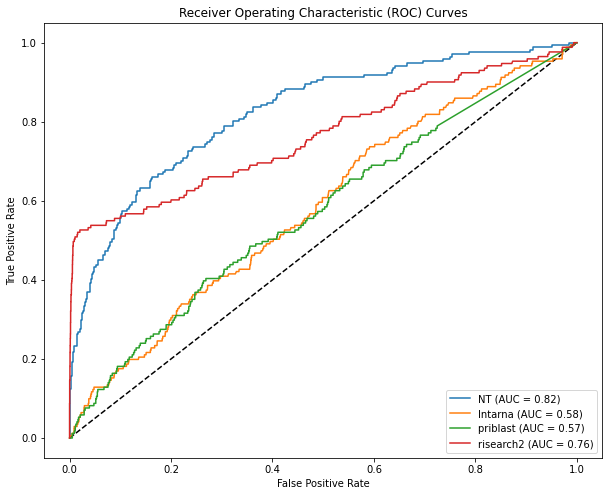

enhn500


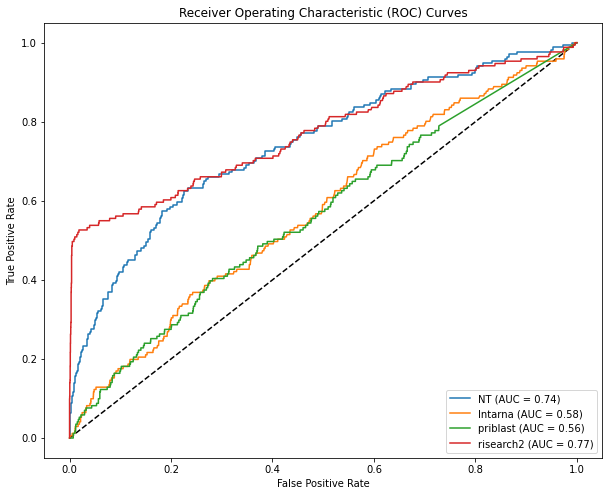




# excluded couples:  12
# excluded couples:  12
# excluded couples:  12
DATASET: splash
easypos_smartneg


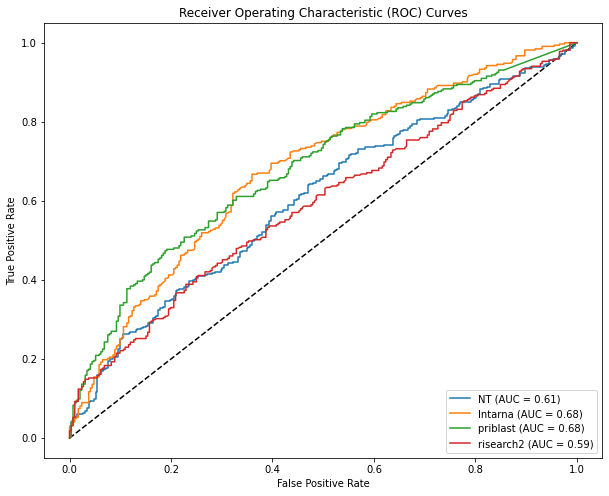

ephnen


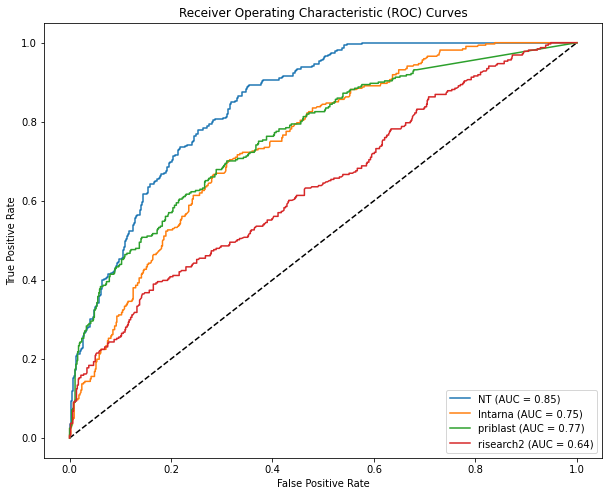

enhn500


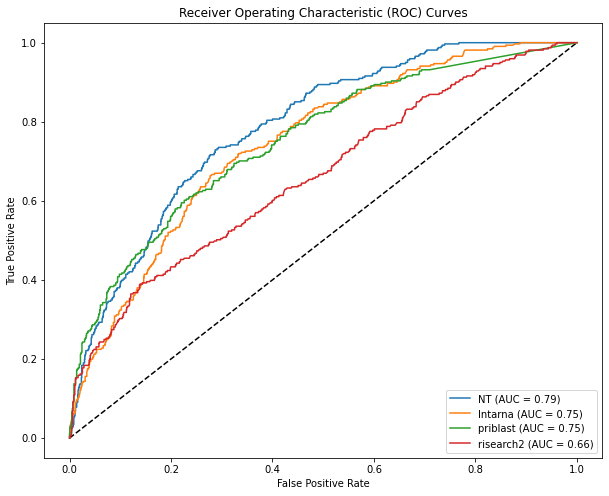




# excluded couples:  4
# excluded couples:  4
# excluded couples:  4
DATASET: mario
easypos_smartneg


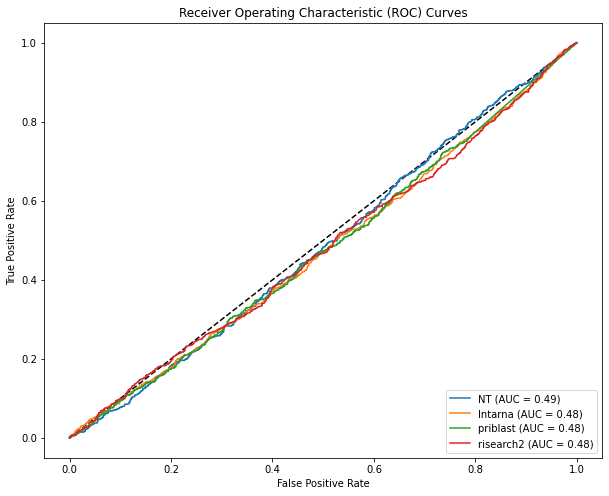

ephnen


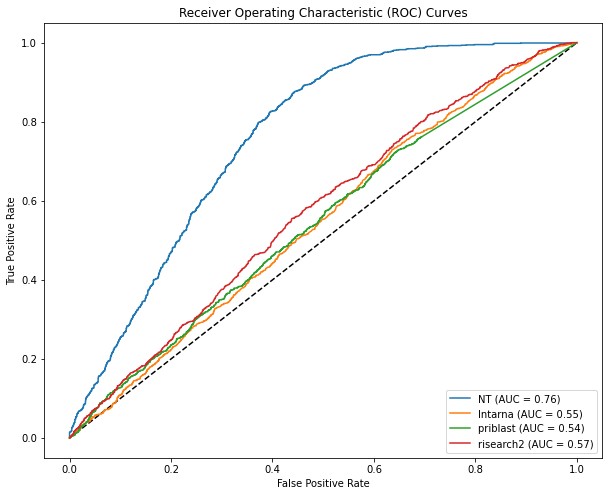

enhn500


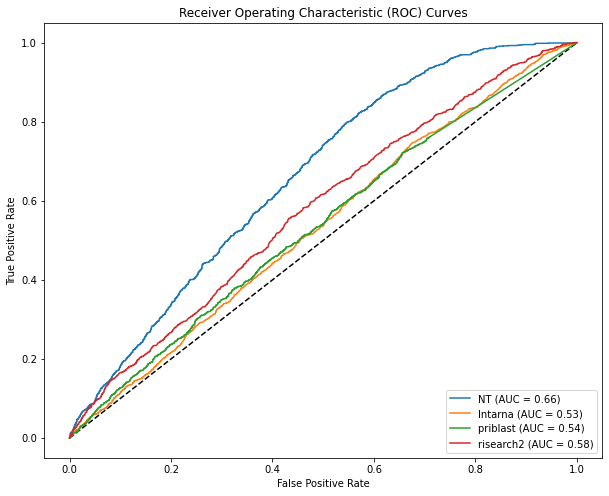

In [5]:
dfs = []

for dataset in datasets:
    how = dataset if dataset != 'paris' else 'test'
    res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS,
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,)
    easypos_smartneg = res[res.policy.isin(['smartneg', 'easypos'])].reset_index(drop = True)
    easypos_smartneg = balance_df(easypos_smartneg)
    dfs.append(obtain_all_model_auc(easypos_smartneg, tools).rename({'auc': f'auc_EPSN_{dataset}'}, axis = 1))
    
    ephnen = res[(res.policy == 'easyneg')|(res.policy == 'easypos')|(res.policy == 'hardneg')].reset_index(drop = True)
    ephnen = balance_df(ephnen)
    dfs.append(obtain_all_model_auc(ephnen, tools).rename({'auc': f'auc_EPENHN_{dataset}'}, axis = 1))
    
    
    
    enhn500 = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                                 args_datasets[how]['only_test'], 
                                 args_datasets[how]['exclude_train_genes'], 
                                 args_datasets[how]['exclude_paris_genes'], 
                                 args_datasets[how]['exclude_paris_couples'],
                                 args_datasets[how]['filter_hq_ricseq'], 
                                 args_datasets[how]['MIN_N_READS_RICSEQ'], 
                                 SPECIE_PARIS,
                                 args_datasets[how]['PARIS_HQ'],
                                 args_datasets[how]['PARIS_HQ_THRESHOLD'],
                                 True
                                )   
    pos = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                             args_datasets[how]['only_test'], 
                             args_datasets[how]['exclude_train_genes'], 
                             args_datasets[how]['exclude_paris_genes'], 
                             args_datasets[how]['exclude_paris_couples'],
                             args_datasets[how]['filter_hq_ricseq'], 
                             args_datasets[how]['MIN_N_READS_RICSEQ'], 
                             SPECIE_PARIS, 
                             args_datasets[how]['PARIS_HQ'],
                             args_datasets[how]['PARIS_HQ_THRESHOLD'],
                             False,
                            )
    pos = pos[pos.policy == 'easypos'].reset_index(drop = True)
    res = pd.concat([pos, enhn500], axis=0).reset_index(drop = True)
    enhn500 = balance_df(res).reset_index(drop = True)
    
    
    print(f'DATASET: {dataset}')
    print('easypos_smartneg')
    plot_all_model_auc(easypos_smartneg, tools)
    print('ephnen')
    plot_all_model_auc(ephnen, tools)
    print('enhn500')
    plot_all_model_auc(enhn500, tools)
    print('\n\n')
    
df_auc = pd.concat(dfs, axis = 1)
df_auc = df_auc.loc[:,~df_auc.columns.duplicated()].copy()

ricseq


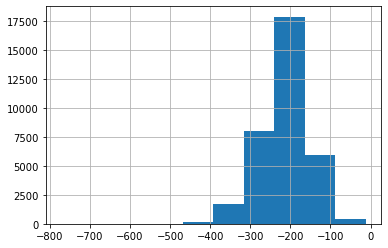

In [6]:
tool_name = 'RNAhybrid' #RNAhybrid
for how in ['ricseq']: #['ricseq', 'mario', 'test', 'splash']
    tool = pd.read_csv(os.path.join(external_dataset_dir, f'{tool_name}_{how}500.csv'), sep = ',').fillna(0)
    tool['value'] = tool['value'].astype(float)
    print(how)
    tool.value.hist()
    plt.show()
    print('\n')

# Model comparison

In [7]:
with open(LR_MAPPING_PATH, 'rb') as file:
    logistic_regression_models = pickle.load(file)

### Plots based on threshold

In [8]:
#plot parameters
MIN_PERC = 0.5 #1 è 1%
list_of_models_to_test = ['nt'] + energy_columns
n_values = 12
n_run_undersampling = 10
list_of_metrics = ['precision', 'npv']
figsize = (17,9)
size_multiplier = 10

balance_predictions_at_each_step = True

checkpoint_dir = [os.path.join(ROOT_DIR, 'checkpoints', _) for _ in nt_models]
list_of_models_to_test = list_of_models_to_test + [f'nt{_}' for _ in range(1, len(nt_models))]

# Repeats enrichment

In Paris, le SR sono > delle non SR solo se paris_hq = False, quindi solo se non consideriamo nei positivi.

In [9]:
#analysis args
feature_to_search = 'Simple_repeat'


full_overlap = False
if full_overlap:
    suffix = 'full_'
else:
    suffix = ''
    
both_sr_condition = True

In [10]:
#kde plot args
figsize_kde = (7, 4)

#treshold plot args
figsize_treshold = (17,9)
MIN_PERC = 1
n_values = 12
size_multiplier = 0
n_run_undersampling = 15
list_of_metrics = ['recall', 'precision_recall_curve']
plot_function = plot_results_based_on_topbottom_for_all_models
tasks_treshold = ['simple_repeat_EPSN', 'no_simple_repeat_EPSN']

In [11]:
dataset = 'paris'
how = 'test'
res = load_res_and_tools(external_dataset_dir, checkpoint_dir, tools, dataset, how, 
                         args_datasets[how]['only_test'], 
                         args_datasets[how]['exclude_train_genes'], 
                         args_datasets[how]['exclude_paris_genes'], 
                         args_datasets[how]['exclude_paris_couples'],
                         args_datasets[how]['filter_hq_ricseq'], 
                         args_datasets[how]['MIN_N_READS_RICSEQ'], 
                         SPECIE_PARIS, 
                         args_datasets[how]['PARIS_HQ'],
                         args_datasets[how]['PARIS_HQ_THRESHOLD'],
                         False)

In [12]:
for model_column in energy_columns:
    lrm_dict = logistic_regression_models[model_column]
    X_test = np.expand_dims(res[model_column], 1)
    y_pred = log_func(lrm_dict['intercept'], lrm_dict['coef'], X_test)
    res[model_column] = pd.Series(y_pred.flatten()) #modify column according to the model mapping

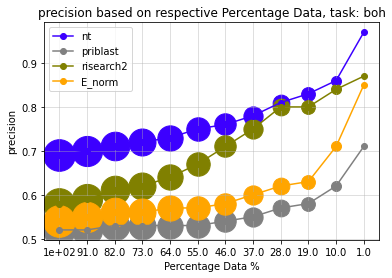

In [13]:
%load_ext autoreload
%autoreload 2
from util.evaluation import load_paris_results, load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df, plot_histogram_01, remove_outliers, log_func, load_res_and_tools, plot_all_model_auc, plot_all_model_auc, obtain_all_model_auc, obtain_subset_from_task, plot_results_of_all_models, obtain_sr_nosr, make_plot_kde_and_test_difference
from util.plot_utils import plot_results_based_on_treshold_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models

subset_to_plot = res.copy()

plot_results_based_on_topbottom_for_all_models(subset_to_plot, MIN_PERC = 1, 
                          list_of_models_to_test = ['nt', 'priblast', 'risearch2', 'E_norm'], 
                          n_values = 12, n_run_undersampling = 1, 
                          metric = 'precision', task_name = 'boh', 
                          size_multiplier = 10#, balance_predictions_at_each_step = True
                         )
plt.show()

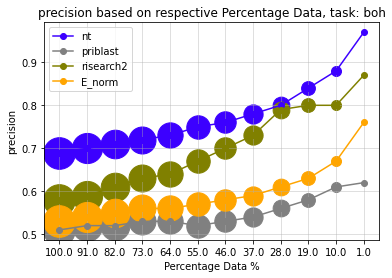

In [14]:
plot_results_based_on_topbottom_for_all_models(subset_to_plot, MIN_PERC = 1, 
                          list_of_models_to_test = ['nt', 'priblast', 'risearch2', 'E_norm'], 
                          n_values = 12, n_run_undersampling = 10, 
                          metric = 'precision', task_name = 'boh', 
                          size_multiplier = 10#, balance_predictions_at_each_step = True
                         )
plt.show()

# RCORDA LEVA OVERSAMPLING DALLO SCRIPT DI EVALUATION.

In [18]:
perc_models = [[100.0, 75.3399525145694, 53.8204187351608, 38.91646881070581, 29.66760198575437, 22.825383121087846, 18.055255773796677, 14.860781351176344, 12.389380530973451, 10.425210446794733, 8.385495359378373, 0], [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0], [100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]]

In [25]:
perc_runs = []
for _ in range(10):
    perc_runs.append(perc_models)

In [29]:
len(np.mean(perc_runs, axis = 0))

4